In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Generate points for calibrating camera - find chessboard conners for all images in `camera_cal` directory

In [2]:
IMG_DIR = 'camera_cal'  # where to find images for camera calibrating
NX, NY = 9, 6  # number of points on a chessboard

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane.

objp = np.zeros((NX * NY, 3), np.float32)
objp[:, :2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

# get the list of calibration images
images = [os.path.join(IMG_DIR, filename) for filename in os.listdir(IMG_DIR)]

for image in images:
    img = cv2.imread(image)

    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

Example of a chessboard image before and after camera calibrating

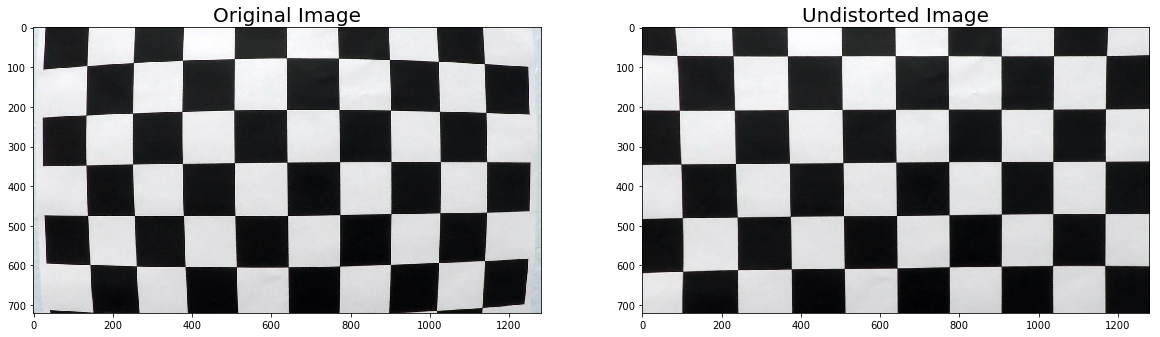

In [3]:
test_image = 'camera_cal/calibration1.jpg'
img = cv2.imread(test_image)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

Example of undistorted road image

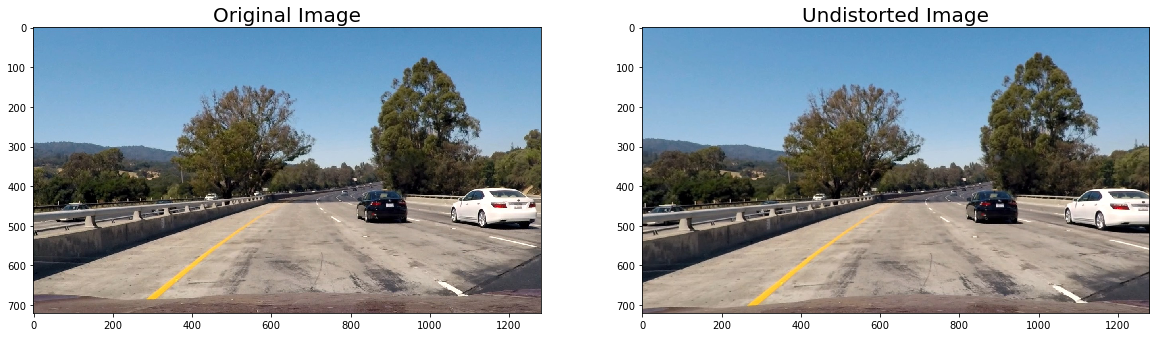

In [4]:
test_image = 'test_images/test1.jpg'
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[1], img.shape[0]), None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

Get rectangle coordinates on an image with straight lane lines to calculate parameters for perspective transformation

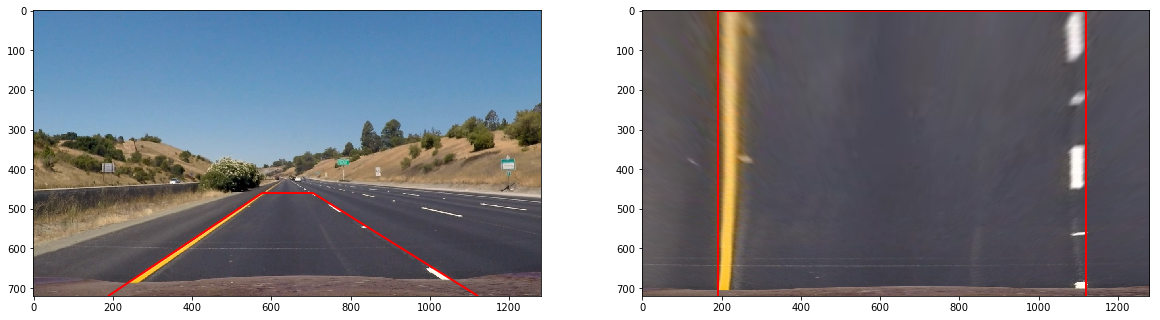

In [5]:
test_image = 'test_images/straight_lines1.jpg'
img = cv2.imread(test_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
from matplotlib.path import Path
import matplotlib.patches as patches
height = img.shape[0]

src = np.float32([(190, 719), (577, 460), (705, 460), (1120, 719)])
dst = np.float32([(190, 719), (190, 0), (1120, 0), (1120, 719)])

plt.subplots(figsize=(20, 10))

plt.subplot(121)
plt.imshow(img)
plt.plot([src[i][0] for i in range(4)],
         [src[i][1] for i in range(4)],
         'r-', lw=2)

plt.subplot(122)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
plt.imshow(warped)
plt.plot([dst[i][0] for i in range(4)], [dst[i][1] for i in range(4)], 'r-', lw=2)

Draw different RGB and HLS channels to select one for lane detection

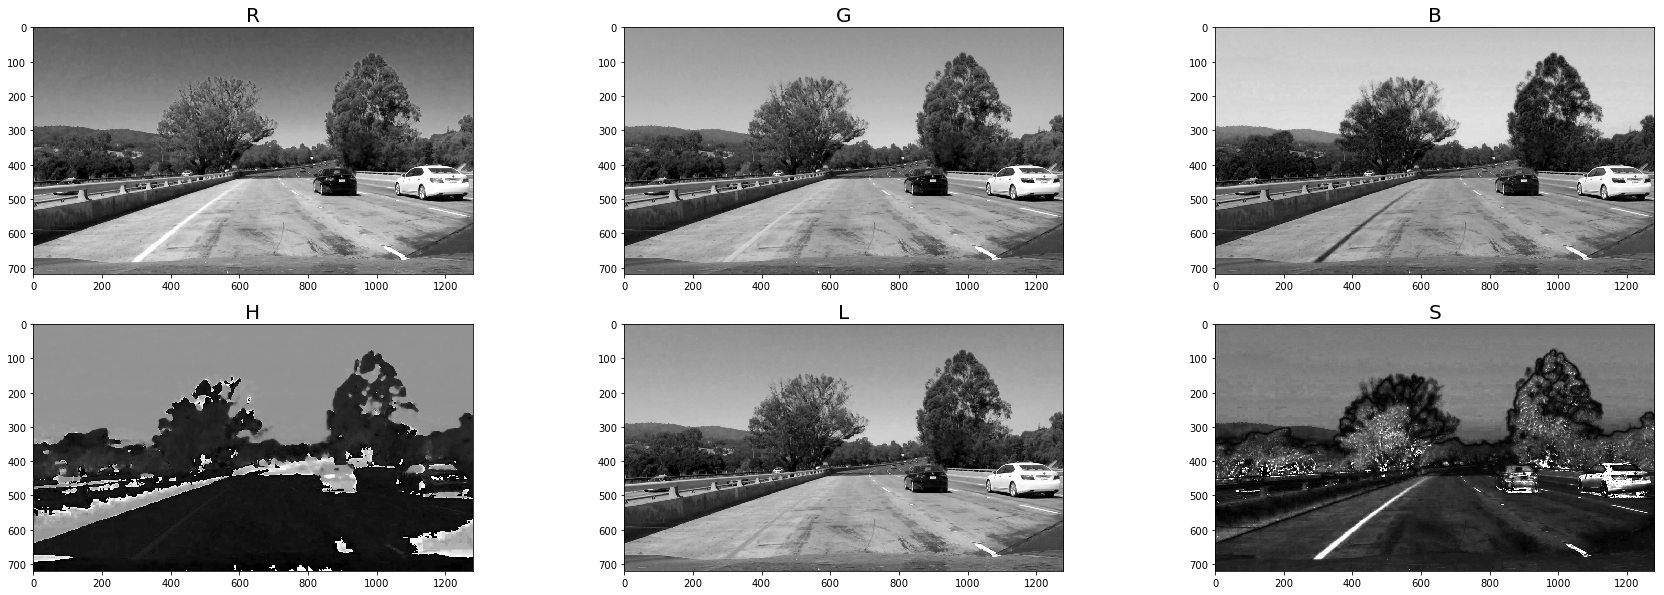

In [6]:
test_image = 'test_images/test1.jpg'
img = cv2.imread(test_image)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30, 10))

for i in range(3):
    ax = plt.subplot(2, 3, i + 1)
    ax.set_title('RGB'[i], fontsize=20)
    ax.imshow(rgb[:, :, i], cmap='gray')

for i in range(3):
    ax = plt.subplot(2, 3, i + 4)
    ax.set_title('HLS'[i], fontsize=20)
    ax.imshow(hls[:, :, i], cmap='gray')

Channel S of HLS looks better than others, create binary image from it

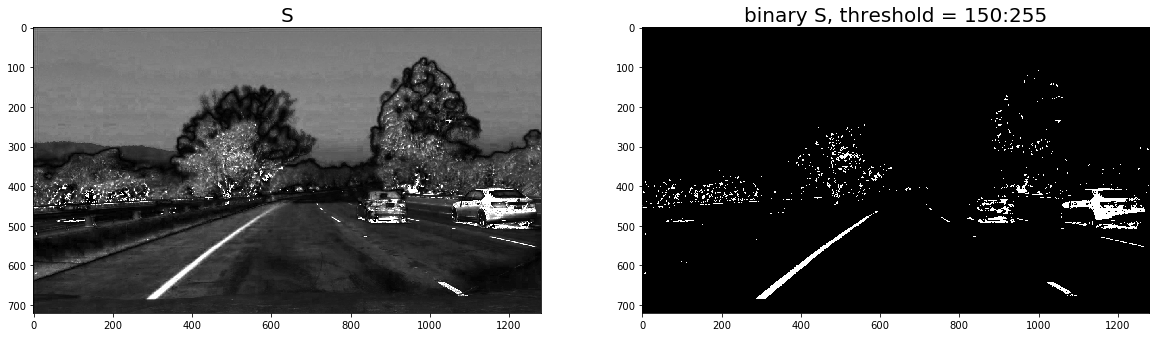

In [7]:
s = hls[:, :, 2]
thresh = (150, 255)
s_binary = np.zeros_like(s)
s_binary[(s >= thresh[0]) & (s <= thresh[1])] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(s, cmap='gray')
ax1.set_title('S', fontsize=20)
ax2.imshow(s_binary, cmap='gray')
ax2.set_title('binary S, threshold = {}:{}'.format(*thresh), fontsize=20)

Create binary image from gradient

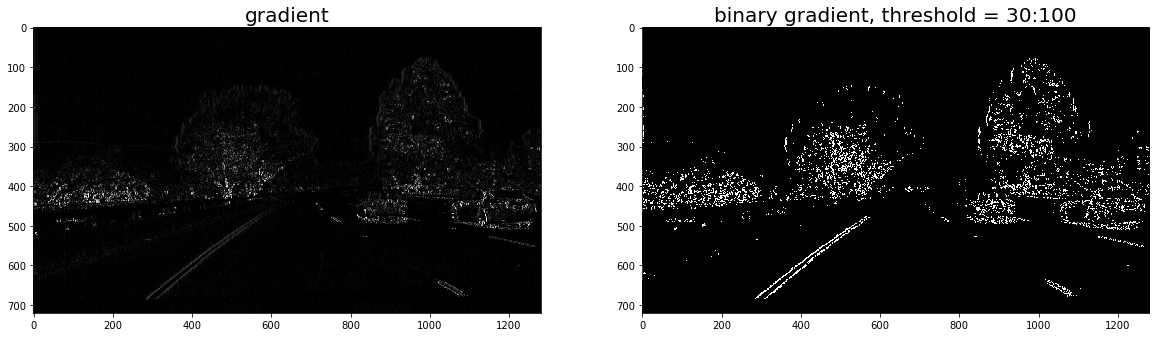

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobel = cv2.Sobel(s, cv2.CV_64F, 1, 0)
sobel = np.absolute(sobel)
sobel = np.uint8(255 * sobel / np.max(sobel))
thresh = (30, 100)
sobel_binary = np.zeros_like(sobel)
sobel_binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(sobel, cmap='gray')
ax1.set_title('gradient', fontsize=20)
ax2.imshow(sobel_binary, cmap='gray')
ax2.set_title('binary gradient, threshold = {}:{}'.format(*thresh), fontsize=20)

Combine both S channel and gradient in one binary image

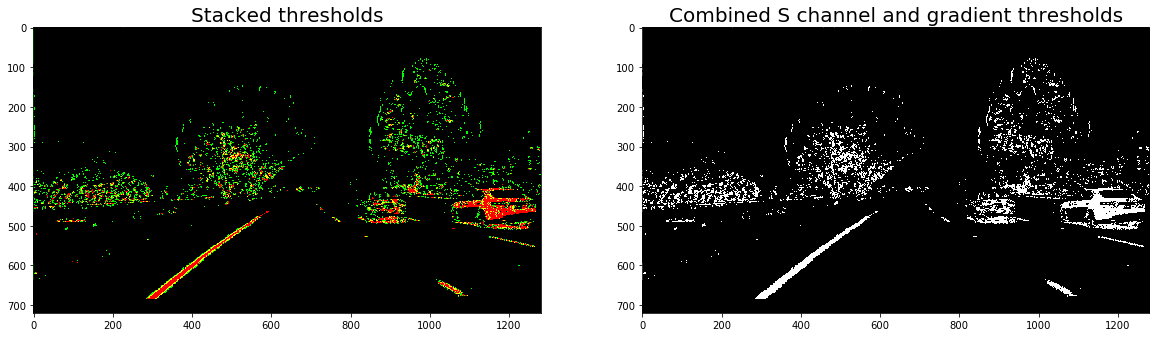

In [9]:
color_binary = np.dstack((255 * s_binary, 255 * sobel_binary, np.zeros_like(s_binary)))

# Combine the two binary thresholds
combined_binary = np.zeros_like(s_binary)
combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Stacked thresholds', fontsize=20)
ax1.imshow(color_binary, cmap='gray')

ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
ax2.imshow(combined_binary, cmap='gray')

Draw combined binary image transformed to plain

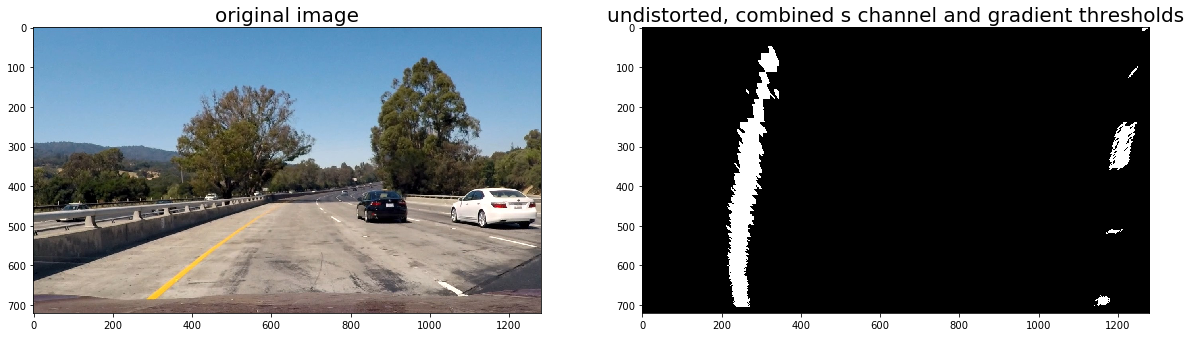

In [10]:
warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('original image', fontsize=20)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax2.set_title('undistorted, combined s channel and gradient thresholds', fontsize=20)
ax2.imshow(warped, cmap='gray')

Histogram to find lane lines

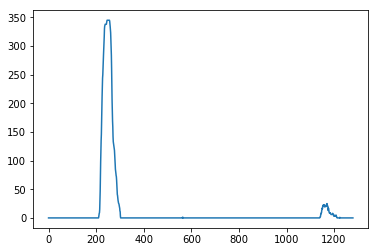

In [11]:
histogram = np.sum(warped[warped.shape[0] // 2:,:], axis=0)
plt.plot(histogram)

Use histogram and sliding windows to find pixels of left and right lane lines, find 2-nd degree polynom which describes lane line curve.

(720, 0)

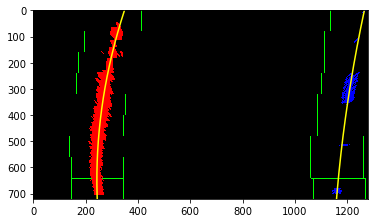

In [12]:
img = warped
out_img = np.dstack((img, img, img)) * 255
midpoint = np.int(histogram.shape[0] / 2)
lx_base = np.argmax(histogram[:midpoint])
rx_base = np.argmax(histogram[midpoint:]) + midpoint

n_windows = 9
window_height = np.int(img.shape[0] / n_windows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
lx_current = lx_base
rx_current = rx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
l_indices = []
r_indices = []

# Step through the windows one by one
for w in range(n_windows):
    # Identify window boundaries in x and y (and right and left)
    y = (img.shape[0] - (w + 1) * window_height, img.shape[0] - w * window_height)
    x = ((lx_current - margin, lx_current + margin),  # left low, left high
         (rx_current - margin, rx_current + margin))  # right low, right high
    
    # Identify the nonzero pixels in x and y within the window
    good = []
    for side in (0, 1):
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (x[side][0], y[0]), (x[side][1], y[1]), (0, 255, 0), 2)
        good.append(((nonzeroy >= y[0]) & (nonzeroy < y[1]) & (nonzerox >= x[side][0]) & (nonzerox < x[side][1])).nonzero()[0])
    # Append these indices to the lists
    l_indices.append(good[0])
    r_indices.append(good[1])
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good[0]) > minpix:
        lx_current = np.int(np.mean(nonzerox[good[0]]))
    if len(good[1]) > minpix:        
        rx_current = np.int(np.mean(nonzerox[good[1]]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(l_indices)
right_lane_inds = np.concatenate(r_indices)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0] - 1, img.shape[0] )
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

Get curvature radius

In [13]:
y = np.max(ploty)
left_curverad = ((1 + (2 * left_fit[0] * y + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
right_curverad = ((1 + (2 * right_fit[0] * y + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
print(left_curverad, right_curverad)

1992.52735814 5499.17648486


Convert radius to meters

In [14]:
ym_per_pix = 30 / 720  # meters per pixel in y dimension
xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2 * left_fit_cr[0] * y * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
right_curverad = ((1 + (2 * right_fit_cr[0] * y * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

653.190505844 m 1788.63679592 m


Create function with full pipeline. Add caching to draw average lane line for several frames, draw previous found line if current line can't be found.

In [15]:
class Cache:
    def __init__(self, size=10):
        self.left = []
        self.right = []
        self.size = size
        self.frame = 0
        self.no_lanes = False

In [16]:
def curvature(ploty, fit):
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    y = np.max(ploty)
    
    # Fit new polynomials to x, y in world space
    fit_cr = np.polyfit(ploty * ym_per_pix, fit * xm_per_pix, 2)

    # Calculate the new radii of curvature
    curverad = ((1 + (2 * fit_cr[0] * y * ym_per_pix + fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr[0])
    return int(curverad)

In [17]:
def pipeline(image, mtx, dist, M, Minv, cache):
    img = np.copy(image)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # S channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:, :, 2]
    thresh = (150, 255)
    s_binary = np.zeros_like(s)
    s_binary[(s >= thresh[0]) & (s <= thresh[1])] = 1

    # gradient
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobel = cv2.Sobel(s, cv2.CV_64F, 1, 0)
    sobel = np.absolute(sobel)
    sobel = np.uint8(255 * sobel / np.max(sobel))
    thresh = (30, 100)
    sobel_binary = np.zeros_like(sobel)
    sobel_binary[(sobel >= thresh[0]) & (sobel <= thresh[1])] = 1

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (sobel_binary == 1)] = 1

    # perspective transformation
    warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
    
    histogram = np.sum(warped[warped.shape[0] // 2:,:], axis=0)

    # if binary image has too many pixels (noise) try to use B channel instead of S one
    if np.sum(warped[warped.shape[0] // 2:,:]) > 50000:
        thresh = (120, 255)
        b = img[:, :, 0]
        b_binary = np.zeros_like(b)
        b_binary[(b >= thresh[0]) & (b <= thresh[1])] = 1

        combined_binary = np.zeros_like(b_binary)
        combined_binary[(b_binary == 1) | (sobel_binary == 1)] = 1

        # recalculate warped image and histogram
        warped = cv2.warpPerspective(combined_binary, M, (img.shape[1], img.shape[0]))
        histogram = np.sum(warped[warped.shape[0] // 2:,:], axis=0)
        
    out_img = np.dstack((warped, warped, warped)) * 255
    midpoint = np.int(histogram.shape[0] / 2)
    lx_base = np.argmax(histogram[:midpoint])
    rx_base = np.argmax(histogram[midpoint:]) + midpoint

    n_windows = 9
    window_height = np.int(img.shape[0] / n_windows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped[:680,:].nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    lx_current = lx_base
    rx_current = rx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    l_indices = []
    r_indices = []
      
    if not cache.left or not cache.right or cache.no_lanes:  # use sliding windows if no lanes were found in previous frames
        # Step through the windows one by one
        for w in range(n_windows):
            # Identify window boundaries in x and y (and right and left)
            y = (img.shape[0] - (w + 1) * window_height,
                 img.shape[0] - w * window_height)
            x = ((lx_current - margin, lx_current + margin),  # left low, left high
                 (rx_current - margin, rx_current + margin))  # right low, right high

            # Identify the nonzero pixels in x and y within the window
            good = []
            for side in (0, 1):
                good.append(((nonzeroy >= y[0]) & (nonzeroy < y[1]) & (nonzerox >= x[side][0]) & (nonzerox < x[side][1])).nonzero()[0])
            # Append these indices to the lists
            l_indices.append(good[0])
            r_indices.append(good[1])
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good[0]) > minpix:
                lx_current = np.int(np.mean(nonzerox[good[0]]))
            if len(good[1]) > minpix:        
                rx_current = np.int(np.mean(nonzerox[good[1]]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(l_indices)
        right_lane_inds = np.concatenate(r_indices)
    else:  # if cache isn't empty
        left_fit = cache.left[-1]
        right_fit = cache.right[-1]
        left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - 3 * margin))
                          & (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + 3 * margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - 3 * margin))
                           & (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + 3 * margin)))  
        if not left_lane_inds.size or right_lane_inds.size:
            cache.no_lanes = True

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to left
    if lefty.size and leftx.size:
        left_fit = np.polyfit(lefty, leftx, 2)
        # sanity check that found pixels are enough to get curve
        if len(leftx) >= 50 and lefty.max() - lefty.min() > window_height:
            cache.left.append(left_fit)
    
    # Fit a second order polynomial to right
    if righty.size and rightx.size:
        right_fit = np.polyfit(righty, rightx, 2)
        # sanity check that found pixels are enough to get curve
        if len(rightx) >= 50 and righty.max() - righty.min() > window_height:
            cache.right.append(right_fit)

    # Control cache size
    if len(cache.left) > cache.size:
        cache.left = cache.left[len(cache.left) - cache.size:]
    if len(cache.right) > cache.size:
        cache.right = cache.right[len(cache.right) - cache.size:]

    # Get average polynom constants
    left_fit = np.mean(cache.left, 0)
    right_fit = np.mean(cache.right, 0)

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Draw curvature radius right on the image
    l_rad = curvature(ploty, left_fitx)
    r_rad = curvature(ploty, right_fitx)
    center = ((img.shape[1] / 2 - (right_fitx[-1] - left_fitx[-1]) / 2 - left_fitx[-1])) * 3.7 / 700
    
    if not cache.frame % 10:
        cache.rad = (l_rad + r_rad) / 2
        cache.center = center
        
    cv2.putText(result, "curve radius: {}m.".format(cache.rad),
                (50, 50), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 255))
    cv2.putText(result, "shift from center: {:.2f}m.".format(cache.center),
                (50, 100), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 0, 255))
    

    cache.frame += 1
    return result

Check pipeline on test images, cache isn't used

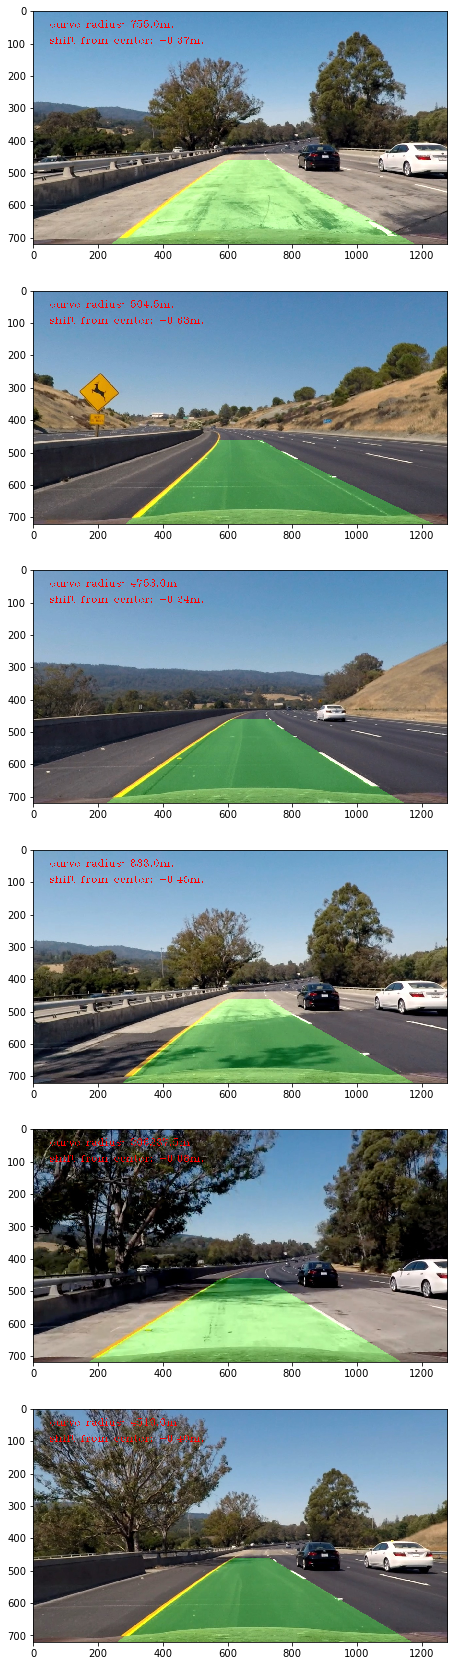

In [18]:
import glob
images = glob.glob('test_images/test*')
plt.subplots(figsize=(10, 30))
for i, test_image in enumerate(images):
    img = cv2.imread(test_image)
    plt.subplot(len(images), 1, i + 1)
    plt.imshow(cv2.cvtColor(pipeline(img, mtx, dist, M, Minv, Cache(1)), cv2.COLOR_BGR2RGB))

Process video

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    global cache
    result = pipeline(image, mtx, dist, M, Minv, cache)
    return result

In [21]:
cache = Cache(5)
output = 'project_video_result.mp4'
clip1 = VideoFileClip('project_video.mp4')
clip = clip1.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:18<00:00,  5.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 4min 21s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))